In [16]:
import datatable as dt
import numpy as np
import matplotlib.pyplot as plt

# Import data set
train = dt.fread('voterfile.csv').to_pandas()
train = train.set_index('optimus_id', drop=True)
train.rename(columns={"maritalstatus": "marital_status", 'occupationindustry': 'occupation_industry'}, inplace=True)

In [17]:
# Have a look at the first five rows
train.head()

,age,party,ethnicity,marital_status,dwellingtype,income,education,cd,dma,occupation_industry,...,intrst_musical_instruments_in_hh,donates_to_liberal_causes,donates_to_conservative_causes,home_owner_or_renter,g08_precinct_turnout,g10_precinct_turnout,g12_precinct_turnout,p08_precinct_turnout,p10_precinct_turnout,p12_precinct_turnout
optimus_id,,,,,,,,,,,,,,,,,,,,,
861681,69.0,Republican,European,Married,Single Family Dwelling Unit,75k-125k,Bach Degree - Extremely Likely,4.0,LAS VEGAS DMA (EST.),Medical,...,nan,NaN,nan,Likely Homeowner,0.56,0.54,0.75,0.17,0.32,0.24
1084850,20.0,American Independent,European,nan,nan,Unknown,nan,2.0,RENO DMA (EST.),nan,...,nan,NaN,nan,nan,0.84,0.82,0.92,0.47,0.62,0.47
644435,28.0,Non-Partisan,European,nan,nan,Unknown,nan,3.0,LAS VEGAS DMA (EST.),nan,...,nan,NaN,nan,nan,0.49,0.34,0.70,0.04,0.09,0.06
57683,78.0,American Independent,European,Married,nan,Unknown,nan,3.0,LAS VEGAS DMA (EST.),nan,...,nan,NaN,nan,nan,0.84,0.79,0.91,0.24,0.46,0.30
167371,68.0,Democratic,nan,nan,nan,Unknown,nan,4.0,LAS VEGAS DMA (EST.),nan,...,nan,NaN,nan,nan,0.71,0.66,0.81,0.19,0.37,0.34


These columns will be dropped because of the following reasons:
* dwelling_type: It's irrelevant, and income can make it up
* net_worth: High multi-colinearity with income, and also the missing values account for over 50%
* petowner_dog: It's irrelevant
* intrst_nascar_in_hh: It's irrelevant
* intrst_musical_instruments_in_hh: It's irrelevant
* home_owner_or_renter: It's irrelevant

In [18]:
train.drop(
    columns=['dwellingtype', 'net_worth', 'petowner_dog', 'intrst_nascar_in_hh', 'intrst_musical_instruments_in_hh',
             'home_owner_or_renter'], inplace=True)

<AxesSubplot:>

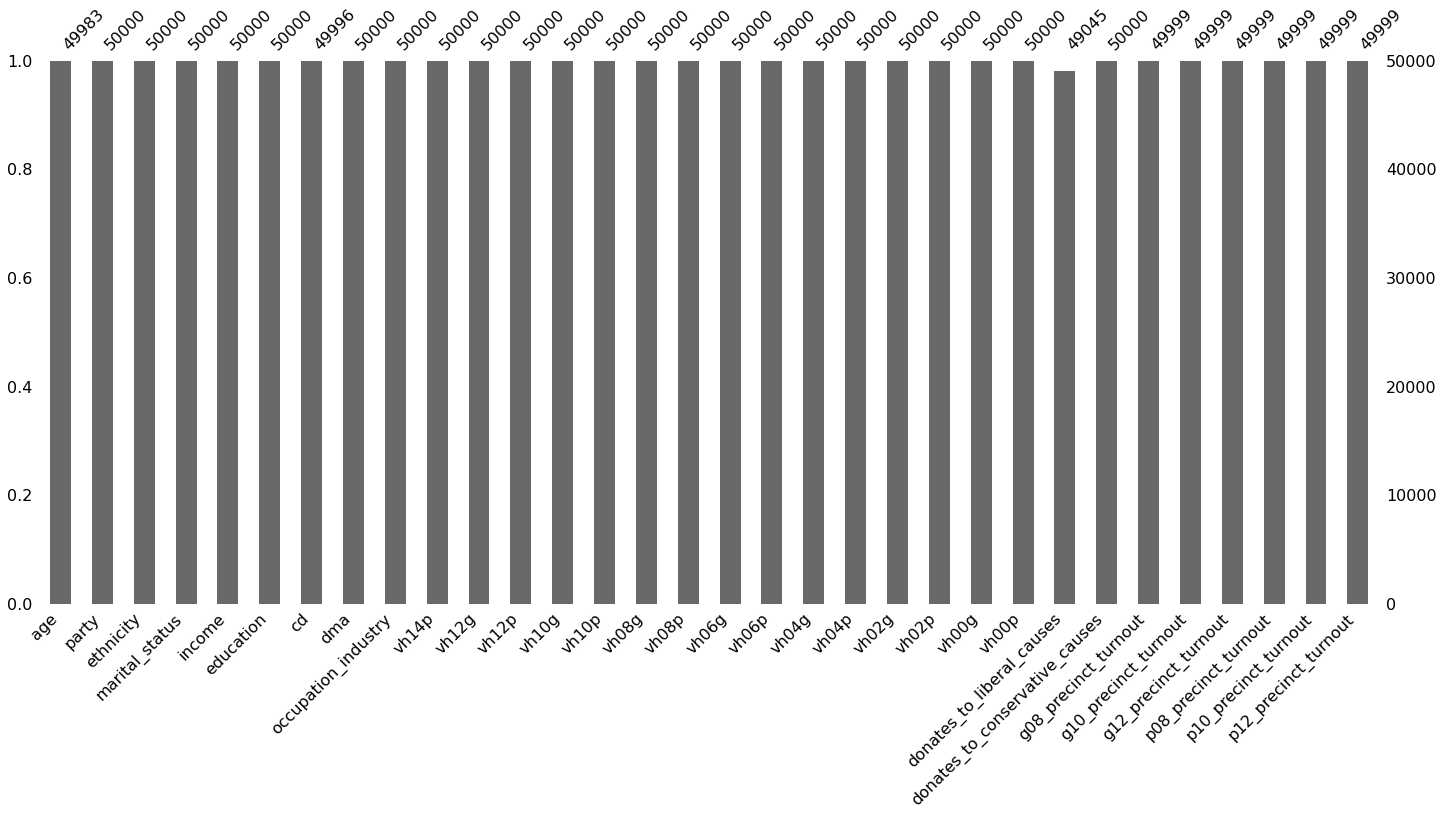

In [19]:
# Check for missing data
import missingno as msno

msno.bar(train)

Even though some columns show that there are missing data under value "nan", neither this chart nor method DataFrame.info() reflect that. Thus, I have to have a closer look at each column's values

Numeric: age

Categorical: ethnicity


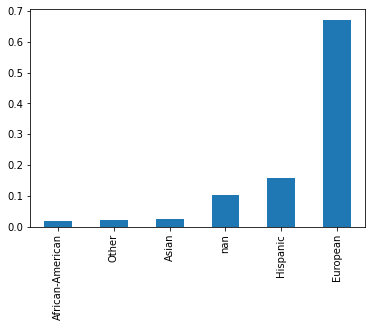


Categorical: marital_status


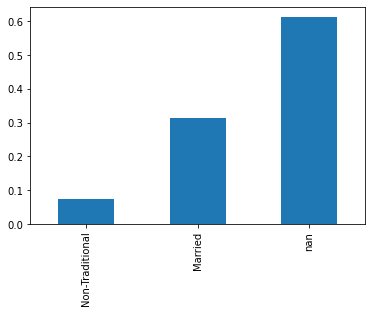


Categorical: education


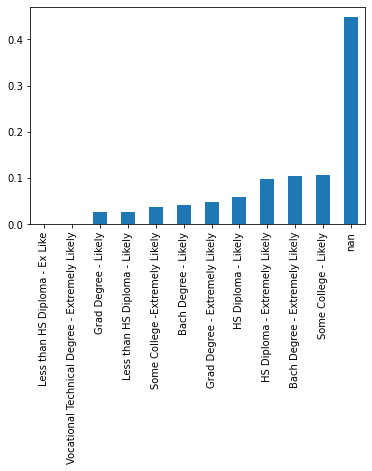


Numeric: cd

Categorical: occupation_industry


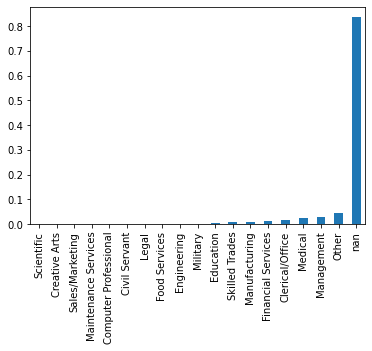


Categorical: donates_to_liberal_causes


C:\Users\Admin\AppData\Local\Temp/ipykernel_5356/3477306481.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if train[col].isnull().sum() > 0 or 'nan' in train[col].unique():


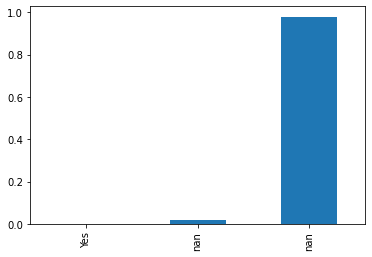


Categorical: donates_to_conservative_causes


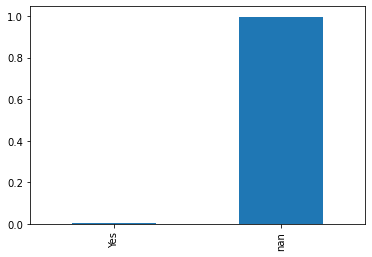


Numeric: g08_precinct_turnout

Numeric: g10_precinct_turnout

Numeric: g12_precinct_turnout

Numeric: p08_precinct_turnout

Numeric: p10_precinct_turnout

Numeric: p12_precinct_turnout



In [21]:
for col in train.columns:
    # If column has missing data
    if train[col].isnull().sum() > 0 or 'nan' in train[col].unique():
        # Numeric type
        if col in train.select_dtypes(np.number).columns:
            print(f'Numeric: {col}')
        # String type
        else:
            print(f'Categorical: {col}')
            train[col].value_counts(normalize=True, dropna=False).sort_values().plot(kind='bar')
            plt.show()
        print()

This is my thoughts about each column that has missing data:
* Ethnicity: Even there are “other” values in this column, “nan” still exists, which may indicate a missing-not-at-random pattern (for example, “mixed” type). Thus, nan will be converted to “Unknown” (no imputation)
* Marital status: The missing value outnumbers other values (non-traditional and married) gives me a feeling that this is also a missing-not-at-random pattern. Usually, married and single take the majority part. However, the statistics from https://statisticalatlas.com/place/Nevada/Las-Vegas/Marital-Status shows me that the gap between the two status is not that far (married even outnumbers never married). Therefore, I decide to use the same technique as ethnicity’s
* Education: Same technique as ethnicity’s.
* Occupation industry: As the missing account for over 80% with the existing of “other”, same technique as ethnicity’s.
* donates_to_liberal_causes, donates_to_conservative_causes: In my opinion, they did not want to reveal their political affiliation while those answered “yes” are sure about which party they would like to vote for. Same technique as ethnicity’s.
* Age: Can be imputed using iterative imputation: other features are used.
* Cd: There are only 4 / 50k. Iterative imputation can work it out.
* g08, g10, g12, p08, p10, p12_precinct_turnout: Same as age's.

|Column|Iterative Imputation |“nan” / np.nan to “Unknown” as one category|
|:----|:----|:----|
|Age|✓| |
|Ethnicity| |✓|
|Marital status| |✓|
|Education| |✓|
|cd|✓| |
|Occupation industry| |✓|
|donates_to_liberal_causes | |✓|
|donates_to_conservative_causes| |✓|
|precinct_turnouts|✓| |


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Prepare columns to be handled
nan_to_unknown = ['ethnicity', 'marital_status', 'education', 'occupation_industry',
                  'donates_to_liberal_causes', 'donates_to_conservative_causes']
numpy_nan_to_unknown = ['donates_to_liberal_causes']
nan_to_be_imputed = ['age', 'cd', 'g08_precinct_turnout', 'g10_precinct_turnout', 'g12_precinct_turnout',
                     'p08_precinct_turnout', 'p10_precinct_turnout', 'p12_precinct_turnout']

# Handle columns having missing data
for col in nan_to_unknown:
    train[col].replace(to_replace=r'[nN][aA][nN]', value='Unknown', regex=True, inplace=True)
for col in numpy_nan_to_unknown:
    train[col].replace(to_replace=np.nan, value='Unknown', inplace=True)

for col in nan_to_be_imputed:
    ii = IterativeImputer()
    ii.fit(train[col].values.reshape(-1, 1))
    train[col] = ii.transform(train[col].values.reshape(-1, 1))